## Embedded Faults (interface2d) : repopulation and smoothing

* interface2D objects are advected using the standard parallel swarm advecting routines
* UW2 does not have functionality for managing the density of 1D swarm objects, so we introduce some functionality for doing that
* Note that much of this functionality is not well tested

In [49]:
import numpy as np
import underworld as uw
from underworld import function as fn
import glucifer
import operator
import UWsubduction as usub
from UWsubduction.interfaces.smoothing2D import *

In [34]:

resX = 12
resY = 12
elementType="Q1/dQ0"

mesh = uw.mesh.FeMesh_Cartesian( elementType = (elementType), 
                                 elementRes  = ( resX, resY), 
                                 minCoord    = ( -0.5, -0.5), 
                                 maxCoord    = ( 0.5, 0.5)  ) 


velocityField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=mesh.dim )

velocityField.data[:] = [0.,0.]


In [35]:
coordinate = fn.input()
yFn = coordinate[1]

In [36]:
velocityField.data[:,0] = 2.*yFn.evaluate(mesh)[:,0] #dVx/dy = 1
velocityField.data[:,1] = 0.

In [37]:
swarm = uw.swarm.Swarm( mesh=mesh, particleEscape=False)
proximityVariable = swarm.add_variable( dataType="int", count=1 )
directorVariable   = swarm.add_variable( dataType="double", count=2)

swarmLayout = uw.swarm.layouts.PerCellSpaceFillerLayout( swarm=swarm, particlesPerCell=20 )
swarm.populate_using_layout( layout=swarmLayout )

proximityVariable.data[:] = 0
directorVariable .data[:] = (0.0, 0.0)

In [40]:
#Set up some embedded faults (interface2D) with npisy data

ds = 1./50

np.random.seed = 1
markerXs = np.arange(-0.5, 0.5, ds) + 0.02*np.random.rand(50)
markerYs = 0.2*np.sin(2.*np.pi*markerXs) + 0.05*np.sin(8.*np.pi*markerXs) + 0.01*np.random.rand(50)


markerThickness = 0.1

ef1 = usub.interface2D(mesh, velocityField, markerXs, markerYs, 
                        markerThickness, 1, insidePt=(0.,-10.))




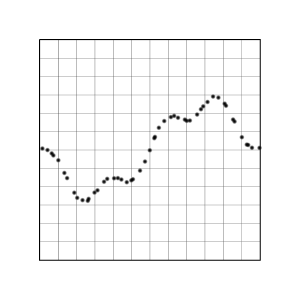

In [41]:
fig1 = glucifer.Figure(figsize=(300,300))
fig1.append(glucifer.objects.Mesh(mesh, opacity= 0.4))
fig1.append( glucifer.objects.Points(ef1.swarm, pointsize = 5))

fig1.show()

In [44]:
usub.interfaces.repair_interface2D?

In [42]:
usub.interfaces.repair_interface2D(ef1, ds, smoothCycles=5, k=8)


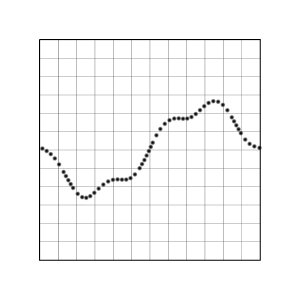

In [43]:
fig2 = glucifer.Figure(figsize=(300,300))
fig2.append(glucifer.objects.Mesh(mesh, opacity= 0.4))
fig2.append( glucifer.objects.Points(ef1.swarm, pointsize = 5))

fig2.show()

In [50]:
a = ef1.neighbourMatrix()
#L = testLine.laplacianMatrix(k = 8)
#pd = testLine.pairDistanceMatrix()
    
#l = laplaceVector(testLine, k = 8, limit=0.25)
ndq = neighbourDistanceQuery(ef1, a, _lowdist=1e-10, _updist = False)

In [52]:
neighbourDistanceQuery?

## Healing

In [39]:
from UWsubduction.interfaces.smoothing2D import *

In [40]:
#from usub import *

In [41]:
np.unique(ef1.swarm.particleCoordinates.data[:,0]).shape

(40,)

In [42]:
#line1.rebuild()
out = shadowMask(ef1)


In [44]:
ds = 1.6/40.
A = ef1.neighbourMatrix(k =4, jitter=1e-8)
midPoints, currentIds = neighbourDistanceQuery(ef1, A, _lowdist=0.,_updist= 5.5*ds)

In [45]:
#dummy = usub.pop_or_perish(tm, fCollection, faultMasterSwarm, faultAddFn , ds)


array([ 1,  0,  2,  1,  3,  2,  4,  3,  5,  4,  6,  5,  7,  6,  8,  7,  9,
        8, 10,  9, 11, 10, 12, 11, 13, 12, 14, 13, 15, 14, 16, 15, 17, 16,
       18, 17, 19, 18, 20, 19, 21, 20, 22, 21, 23, 22, 24, 23, 25, 24, 26,
       25, 27, 26, 28, 27, 29, 28, 30, 29, 31, 30, 32, 31, 33, 32, 34, 33,
       35, 34, 36, 35, 37, 36, 38, 37])

## Tests for small data

In [46]:
%load_ext autoreload


In [53]:
markerXs

array([-0.8       , -0.75897436, -0.71794872, -0.67692308, -0.63589744,
       -0.59487179, -0.55384615, -0.51282051, -0.47179487, -0.43076923,
       -0.38974359, -0.34871795, -0.30769231, -0.26666667, -0.22564103,
       -0.18461538, -0.14358974, -0.1025641 , -0.06153846, -0.02051282,
        0.02051282,  0.06153846,  0.1025641 ,  0.14358974,  0.18461538,
        0.22564103,  0.26666667,  0.30769231,  0.34871795,  0.38974359,
        0.43076923,  0.47179487,  0.51282051,  0.55384615,  0.59487179,
        0.63589744,  0.67692308,  0.71794872,  0.75897436,  0.8       ])

In [48]:
fib = lambda n: n if n < 2 else fib(n-1) + fib(n-2)

for i in range(1, 15):
    
    i = fib(i)
    
    testLine = usub.interface2D(mesh, velocityField, markerXs[:i], markerYs[:i], 
                        markerThickness, 1, insidePt=(0.,-10.))
    print(i)
    
    ### basic matrices: methods of markerLine2D
    
    a = testLine.neighbourMatrix()
    L = testLine.laplacianMatrix(k = 8)
    pd = testLine.pairDistanceMatrix()
    
    ### accessory routines: bits of functions from healing2d
    
    l = laplaceVector(testLine, k = 8, limit=0.25)
    ndq = neighbourDistanceQuery(testLine, a, _lowdist=1e-10, _updist = False)
    mask = np.where(a.sum(axis=1) != 2)
    sm = shadowMask(testLine)
    pt = particlesToAdd(testLine, a, _lowdist=0.0001, _updist = False)
    

1
1
2
3
5
8
13
21
34
55
89
144
233
377


In [54]:
#The repair_interface2D routine is supposed to maintain particle density and smooth
usub.interfaces.repair_interface2D(testLine, ds, smoothCycles=1, k=8)